In [1]:
%matplotlib inline

import csv 

import numpy             as np
import pandas            as pd

import seaborn           as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

from sklearn                  import cross_validation, neighbors
from sklearn.base             import BaseEstimator
from sklearn.svm              import SVC
from sklearn.ensemble         import RandomForestClassifier, ExtraTreesClassifier
from sklearn.mixture          import GMM
from sklearn.decomposition    import PCA
from sklearn.metrics          import accuracy_score

In [2]:
# Read in data
labels   = np.asarray(pd.read_csv('./input/trainLabels.csv', header=None)).ravel()
train    = np.asarray(pd.read_csv('./input/train.csv', header=None))    
test     = np.asarray(pd.read_csv('./input/test.csv', header=None))
all_data = np.r_[train, test]

kfold = cross_validation.KFold(len(train), n_folds=5, random_state=111)

CV Scores[1.0, 0.995, 1.0, 0.98999999999999999, 0.995]
Test Points with Confidence > .8: 4484
Test Points with Confidence < .2: 4459


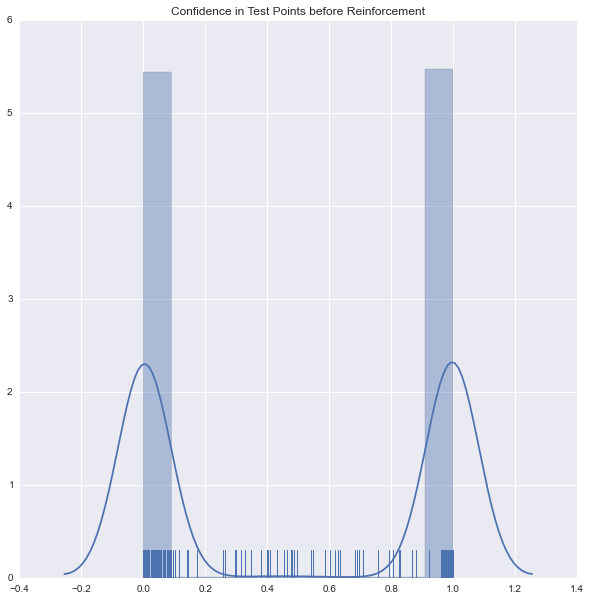

In [3]:
# Transform data using GMM and classify with RF: 
# Reinforce training with high confidence test point and correct the remaining with kNN
# Reaches 0.99256 in private leaderboard

gmm = GMM(n_components=4, covariance_type='full',min_covar=0.0001,tol=0.1)
gmm.fit(all_data)

clf=RandomForestClassifier(n_estimators=5555, random_state=111, verbose=0)
kfold = cross_validation.KFold(len(train), n_folds=5, random_state=111)

all_fits = []
all_scores = []
for trIdx,tsIdx in kfold :
    all_fits.append(clf.fit(gmm.predict_proba(train[trIdx]), labels[trIdx]))
    all_scores.append(all_fits[-1].score(gmm.predict_proba(train[tsIdx]), labels[tsIdx]))

print('CV Scores'+str(all_scores))

test_gmm   = gmm.predict_proba(test)

confidence = np.zeros((9000,5))
for (idx,clf) in enumerate(all_fits):
    temp = clf.predict_proba(test_gmm)
    confidence[:,idx] = temp[:,1]
ensemble_confidence = np.mean(confidence,axis=1)

print('Test Points with Confidence > .8: '+str(sum(ensemble_confidence>=0.75)))
print('Test Points with Confidence < .2: '+str(sum(ensemble_confidence<=0.25)))

plt.figure(figsize=(10,10))
sns.distplot(ensemble_confidence, rug=True)
plt.title('Confidence in Test Points before Reinforcement')

In [4]:
# Reinforce using test points with highest confidence

high_confidence_ones  = np.where(ensemble_confidence>=0.75)[0]
high_confidence_zeros = np.where(ensemble_confidence<=0.25)[0]

reinforcement_labels  = np.r_[
    np.ones(high_confidence_ones.shape[0]),
    np.zeros(high_confidence_zeros.shape[0])]

reinforcement_train  = np.r_[test[high_confidence_ones,:],test[high_confidence_zeros,:]]

reinforcement_train  = np.r_[train, reinforcement_train]
reinforcement_labels = np.r_[labels,reinforcement_labels]

CV Scores[0.99798893916540976, 1.0, 1.0, 1.0, 1.0]
Test Points with Confidence > .8: 4484
Test Points with Confidence < .2: 4481


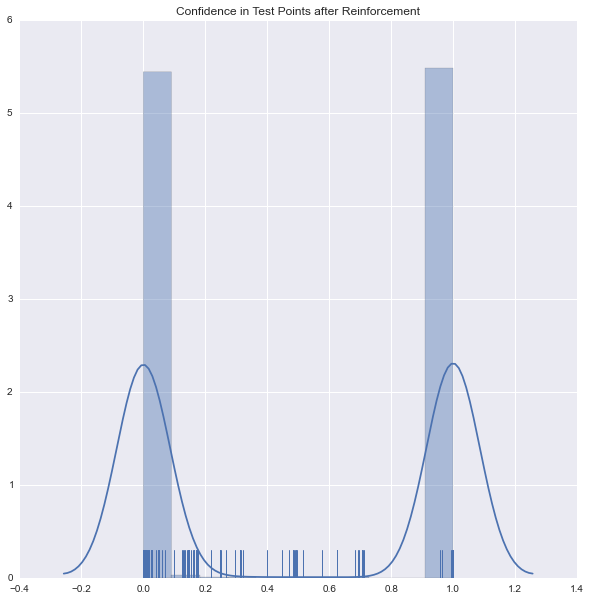

In [5]:
# Repeat same process
clf=RandomForestClassifier(n_estimators=5555, random_state=111, verbose=0)
re_kfold = cross_validation.KFold(len(reinforcement_train), n_folds=5, random_state=111)

all_fits = []
all_scores = []
for trIdx,tsIdx in re_kfold :
    all_fits.append(clf.fit(gmm.predict_proba(reinforcement_train[trIdx]), reinforcement_labels[trIdx]))
    all_scores.append(all_fits[-1].score(gmm.predict_proba(reinforcement_train[tsIdx]), reinforcement_labels[tsIdx]))

print('CV Scores'+str(all_scores))

test_gmm   = gmm.predict_proba(test)

confidence = np.zeros((9000,5))
for (idx,clf) in enumerate(all_fits):
    temp = clf.predict_proba(test_gmm)
    confidence[:,idx] = temp[:,1]
ensemble_confidence = np.mean(confidence,axis=1)

rf_results = np.zeros_like(ensemble_confidence)
rf_results[ensemble_confidence>=0.5] = 1

print('Test Points with Confidence > .8: '+str(sum(ensemble_confidence>=0.75)))
print('Test Points with Confidence < .2: '+str(sum(ensemble_confidence<=0.25)))

plt.figure(figsize=(10,10))
sns.distplot(ensemble_confidence, rug=True)
plt.title('Confidence in Test Points after Reinforcement')

In [6]:
# Correct with KNN

rf_incertitude  = np.intersect1d(np.where(ensemble_confidence>0.25)[0],
                                 np.where(ensemble_confidence<0.75)[0])

incertitude_points = test[rf_incertitude,:]
incertitude_labels = rf_results[rf_incertitude]

knn = neighbors.KNeighborsClassifier(7)
knn.fit(reinforcement_train, reinforcement_labels)
incertitude_predicted      = knn.predict(incertitude_points)
rf_results[rf_incertitude] = incertitude_predicted   

In [7]:
# write submission file for RF
data=[]
for i in range(9000):
    data.append([i+1,int(rf_results[i])])
with open('Result_RF.csv', 'wb') as csvfile:
    out = csv.writer(csvfile, delimiter=',')
    out.writerow(['Id','Solution'])
    out.writerows(data)

In [8]:
class PcaGmm(BaseEstimator):
    def __init__(self, data,
                 pca_components = 12, gmm_components = 4,
                 covariance_type = "full", min_covar = 0.1,
                 gamma = 0, C = 1.0):

        self.pca_components  = pca_components
        self.gmm_components  = gmm_components
        self.covariance_type = covariance_type
        self.min_covar       = min_covar
        self.gamma           = gamma
        self.C               = C
        self.pca             = PCA(n_components = self.pca_components)
        self.pca             = self.pca.fit(data)
        self.pca_data        = self.pca.transform(data)
        self.gmm = GMM(n_components = gmm_components,
                       covariance_type = covariance_type,
                       min_covar = min_covar)
        self.gmm.fit(self.pca_data)

    def fit(self, data, labels):
        data     = self.pca.transform(data)
        data     = self.gmm.predict_proba(data)
        self.svm = SVC(C = self.C, gamma = self.gamma)
        self.svm.fit(data, labels)

    def predict(self, data):
        data     = self.pca.transform(data)
        return self.svm.predict(self.gmm.predict_proba(data))

    def score(self, data, labels):
        return accuracy_score(labels, self.predict(data))

    def gmm_transform(self, data):
        data = self.pca.transform(data)
        return self.gmm.predict_proba(data)
    
    def pca_transform(self, data ):
        return self.pca.transform(data)

In [9]:
# test PCA-SVM separability and performance
pcagmm  = PcaGmm(all_data,12, 4, 'full', 0, gamma = .6, C = 0.3)

all_scores = []
for trIdx,tsIdx in kfold :
    pcagmm  = PcaGmm(all_data,12, 4, 'full', 0, gamma = .6, C = 0.3)
    pcagmm.fit(train[trIdx], labels[trIdx])
    all_scores.append(pcagmm.score(train[tsIdx], labels[tsIdx]))

print('CV Scores Original: '+str(all_scores))

re_all_scores = []
for trIdx,tsIdx in re_kfold :
    pcagmm  = PcaGmm(all_data,12, 4, 'full', 0, gamma = .6, C = 0.3)
    pcagmm.fit(reinforcement_train[trIdx], reinforcement_labels[trIdx])
    re_all_scores.append(pcagmm.score(reinforcement_train[tsIdx], reinforcement_labels[tsIdx]))

print('CV Scores Reinforcement: '+str(re_all_scores))

re_all_results = []
for trIdx,tsIdx in re_kfold :
    pcagmm  = PcaGmm(all_data,12, 4, 'full', 0, gamma = .6, C = 0.3)
    pcagmm.fit(reinforcement_train[trIdx], reinforcement_labels[trIdx])
    re_all_results.append(pcagmm.predict(test))

svc_results = np.mean(np.matrix(re_all_results),axis=0).T    
svc_results = np.array(svc_results).reshape((9000,))

CV Scores Original: [1.0, 0.995, 1.0, 0.98999999999999999, 0.995]
CV Scores Reinforcement: [0.9974861739567622, 0.99949723479135244, 0.99949723479135244, 0.99949698189134806, 1.0]


In [10]:
# write submission file for SVM
data=[]
for i in range(9000):
    data.append([i+1,int(svc_results[i])])
with open('Result_SVC.csv', 'wb') as csvfile:
    out = csv.writer(csvfile, delimiter=',')
    out.writerow(['Id','Solution'])
    out.writerows(data)

In [11]:
# Use SVC prediction to correct RF mispredictions: it doesn't help
temp   = pd.read_csv('./Result_RF.csv', header=0)
rf_results = temp['Solution'].values

temp   = pd.read_csv('./Result_SVC.csv', header=0)
svc_results = temp['Solution'].values

mispredictions  = np.where(rf_results!=svc_results)[0]
c = ensemble_confidence[mispredictions]

ens_results = rf_results.copy()
ens_results[mispredictions[c<0.1]] = svc_results[mispredictions[c<0.1]]
#ens_results[mispredictions] = svc_results[mispredictions]

rf_results[mispredictions[5]]=1
ens_results = rf_results

In [12]:
# write submission file for SVM-RF ensemble + KNN
data=[]
for i in range(9000):
    data.append([i+1,int(ens_results[i])])
with open('Result_Ens.csv', 'wb') as csvfile:
    out = csv.writer(csvfile, delimiter=',')
    out.writerow(['Id','Solution'])
    out.writerows(data)

In [134]:
# write submission file for SVM-RF ensemble + KNN
data=[]
for i in range(9000):
    data.append([i+1,int(ens_results[i])])
with open('Result_Ens.csv', 'wb') as csvfile:
    out = csv.writer(csvfile, delimiter=',')
    out.writerow(['Id','Solution'])
    out.writerows(data)

<matplotlib.colorbar.Colorbar instance at 0x13a098dd0>

/Users/piero/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


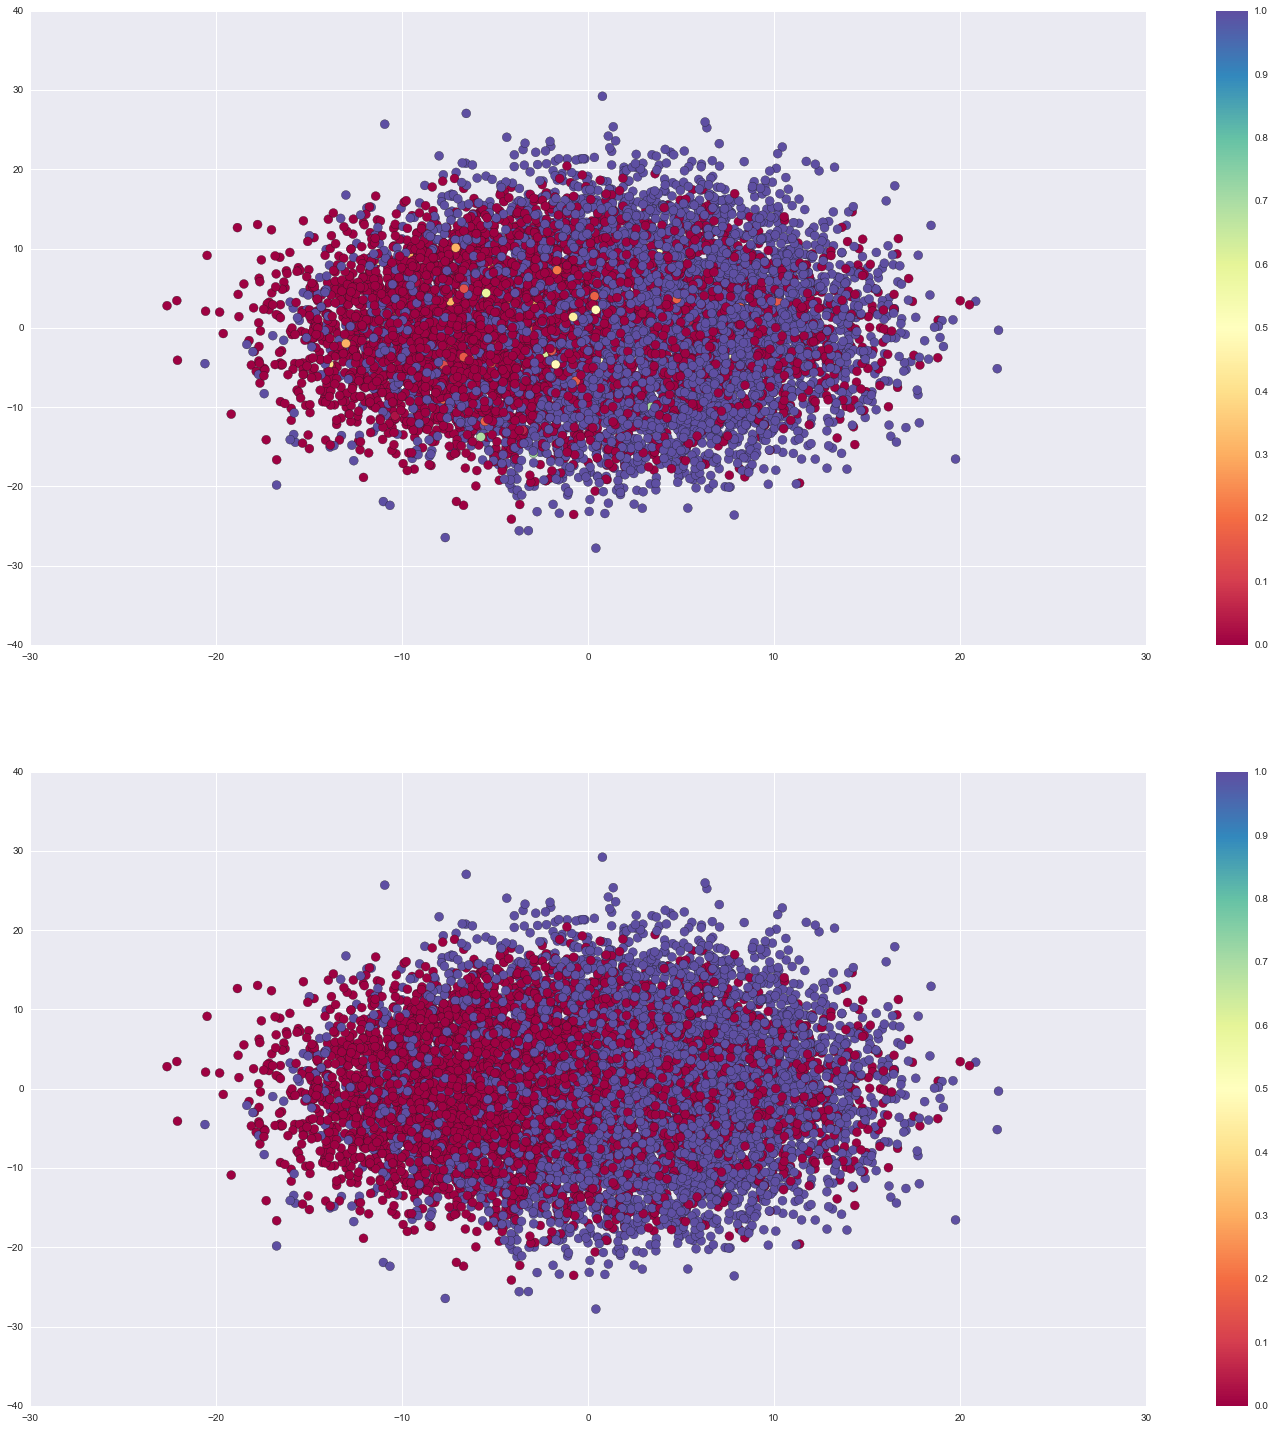

In [13]:
from sklearn import manifold
mds       = manifold.MDS(n_components=2, max_iter=100,n_init=1)
test_mds  = mds.fit_transform(test)
plt.figure(figsize=(25,25))
plt.subplot(211)
plt.scatter(test_mds[:, 0], test_mds[:, 1],s=80,c=ensemble_confidence, cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(212)
plt.scatter(test_mds[:, 0], test_mds[:, 1],s=80,c=svc_results, cmap=plt.cm.Spectral)
plt.colorbar()

(34,)
(34,)


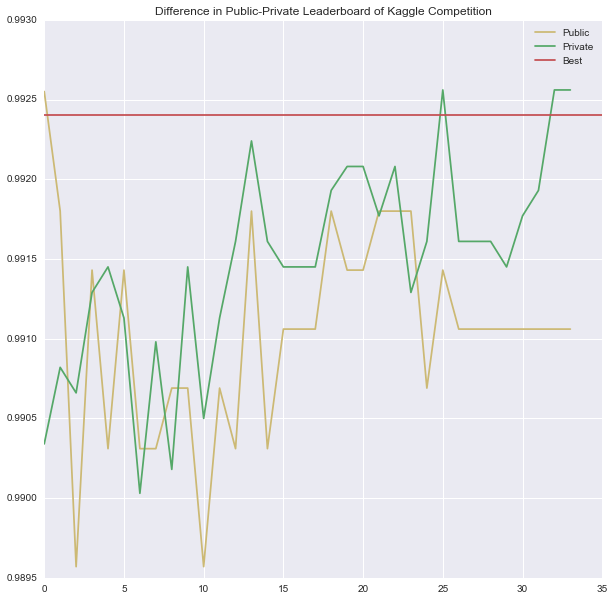

In [226]:
# kaggle leaderboard 
private  = np.array([0.99034,0.99082,0.99066,0.99129,0.99145,0.99113,0.99003,0.99098,0.99018,0.99145,0.99050,0.99113,0.99161,0.99224,0.99161,0.99145,0.99145,0.99145,0.99193,0.99208,0.99208,0.99177,0.99208,0.99129,0.99161,0.99256,0.99161,0.99161,0.99161,0.99145,0.99177,0.99193,0.99256,0.99256])
public   = np.array([0.99255,0.99180,0.98957,0.99143,0.99031,0.99143,0.99031,0.99031,0.99069,0.99069,0.98957,0.99069,0.99031,0.99180,0.99031,0.99106,0.99106,0.99106,0.99180,0.99143,0.99143,0.99180,0.99180,0.99180,0.99069,0.99143,0.99106,0.99106,0.99106,0.99106,0.99106,0.99106,0.99106,0.99106])

print(public.shape)
print(private.shape)
plt.figure(figsize=(10,10))
pub=plt.plot(public,'y',label='Public')
pri=plt.plot(private,'g',label='Private')
best=plt.axhline(y=.9924, xmin=0, xmax=36,color='r',label='Best')
plt.legend()
plt.title('Difference in Public-Private Leaderboard of Kaggle Competition')